# AHSN Project
#### Done by:
Safeyah Alshemali - Hannah  Portes - Aparna Muraleekrishnan

#### Based on Paper: 
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
[link](https://https://arxiv.org/abs/1704.04861)

#### Authors: 
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam


### Code Libraries

Below is the process of loading the data of Imagenette. This tensorflow dataset has 10 classes, 9469 training samples, and 3925 validation samples.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import os

# Import Necessary Modules
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from keras import datasets, layers, models
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation , DepthwiseConv2D, Conv2D, BatchNormalization,  GlobalAveragePooling2D, Activation , Lambda , Reshape, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

### Data Processing

The data set we are using is **Imagenette** which is subset of ImageNet dataset of 10 classes only. This dataset fit the resourses (GPUS) and time limitation [link](https://https://www.tensorflow.org/datasets/catalog/imagenette).

In [9]:
# load the data and info from tfds
data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)

# then split into training and validation subsets
train_data, valid_data = data['train'], data['validation']

In [10]:
image_size = 128
no_classes = 10
# resize the images to 128 x 128 for faster training 
train_dataset = train_data.map(lambda image, label: (tf.image.resize(image, (image_size, image_size)), label))

validation_dataset = valid_data.map(
    lambda image, label: (tf.image.resize(image, (image_size, image_size)), label))

In [11]:
# print general properties of the dataset for information and to verify attributes
# match what we expect
num_train = train_dataset.__len__().numpy()
num_val = validation_dataset.__len__().numpy()

num_classes = info.features['label'].num_classes
print('Total number of classes in dataset: ', num_classes)
print('Number of training samples: ', num_train)
print('Number of validation samples: ', num_val)

Total number of classes in dataset:  10
Number of training samples:  9469
Number of validation samples:  3925


In [12]:
# put train and validation into a list, and one hot encode their respective labels
X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))


X_valid = list(map(lambda x: x[0], validation_dataset))
y_valid = list(map(lambda x: x[1], validation_dataset))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

In [13]:
# Verify shapes
print('Y Train shape: {}'.format(y_train.shape))
print('Y Validation shape: {}'.format(y_valid.shape))
     

Y Train shape: (9469, 10)
Y Validation shape: (3925, 10)


### Data Augmentation

In [14]:
# Define ImageGen for data augmentation 

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      height_shift_range=0.3)

valid_datagen = ImageDataGenerator(
      rescale=1./255)

train_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_train), y=np.array(y_train), image_data_generator=train_datagen,batch_size=32
)

valid_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_valid), y=np.array(y_valid), image_data_generator=valid_datagen,batch_size=32
)

### Data Visualization 

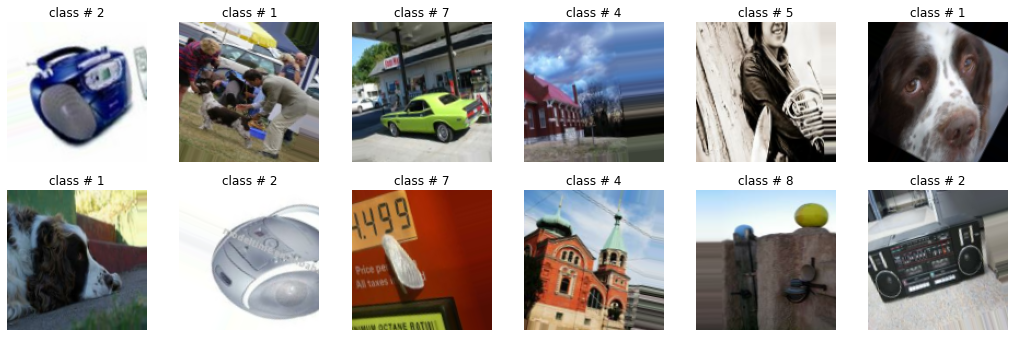

In [15]:
# plot the images
plt.figure(figsize=(18, 18))

num = 0

for i in range(0, 12):
    image,label = next(iter(train_data))
    ax = plt.subplot(6, 6, num + 1)
    plt.imshow(image[0])
    plt.title('class # ' + str(np.argmax(label)))
    plt.axis("off")
    num += 1


### MobileNet Model

The Depthwise Separable Convolution layer

In [16]:
# Function for Depth-wise Convolution Layer
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [17]:
# Function for Point-wise Convolution Layer
def PointWiseConv(filters,alpha,kernal_size, stride, x):
    result = Conv2D(int(alpha*filters), kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

Model Creation

In [18]:
def create_Reduced_MobileNet_model(input_shape, alpha ,no_classes):
    
    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(64,1,(1, 1), (1, 1) ,x)

    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(128,1,(1, 1), (1, 1) ,x)
    
    #4th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(256,1,(1, 1), (1, 1) ,x)

    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(512,1,(1, 1), (1, 1) ,x)

    #6th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(1024,1,(1, 1), (1, 1) ,x)

    #7th layer dropout 
    x = Dropout(0.2)(x)

    #8th layer: Avg Pooling
    x = GlobalAveragePooling2D()(x) 

    #9th layer Dense layer
    out = Dense(no_classes,activation='softmax')(x)

    model = Model(input, out, name='mobilenet')

    return model    

Fitting and Training the Model

In [19]:
MobileNet = create_Reduced_MobileNet_model((image_size,image_size,3),1,no_classes)
MobileNet.summary()


Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        864       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 64, 64, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       12

In [ ]:
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

In [ ]:
#plot the results 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### AlexNet Model

Creating the Model

In [34]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    #keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    #keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(1024,activation='relu'),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')
])

In [35]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.01),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 30, 30, 128)       46592     
                                                                 
 batch_normalization_33 (Bat  (None, 30, 30, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 10, 10, 128)       409728    
                                                                 
 batch_normalization_34 (Bat  (None, 10, 10, 128)      512       
 chNormalization)                                                
                                                      

In [36]:
history=model.fit(
    train_data,
    epochs=50,
    validation_data=valid_data
)

Epoch 1/50
296/296 [==============================] - 37s 121ms/step - loss: 2.0889 - accuracy: 0.2923 - val_loss: 1.8456 - val_accuracy: 0.3506
Epoch 2/50
296/296 [==============================] - 35s 117ms/step - loss: 1.7098 - accuracy: 0.4123 - val_loss: 1.6411 - val_accuracy: 0.4354
Epoch 3/50
296/296 [==============================] - 37s 124ms/step - loss: 1.5571 - accuracy: 0.4756 - val_loss: 1.5384 - val_accuracy: 0.4744
Epoch 4/50
296/296 [==============================] - 35s 119ms/step - loss: 1.4547 - accuracy: 0.5077 - val_loss: 1.4418 - val_accuracy: 0.5052
Epoch 5/50
296/296 [==============================] - 35s 117ms/step - loss: 1.3519 - accuracy: 0.5478 - val_loss: 1.3004 - val_accuracy: 0.5684
Epoch 6/50
296/296 [==============================] - 35s 117ms/step - loss: 1.3072 - accuracy: 0.5632 - val_loss: 1.6190 - val_accuracy: 0.4820
Epoch 7/50
296/296 [==============================] - 34s 116ms/step - loss: 1.2330 - accuracy: 0.5889 - val_loss: 1.4055 - val_ac